<a href="https://colab.research.google.com/github/hkrsmk/beepboop-shopee-code-league-2020/blob/master/pdt_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import from google cloud storage

In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
! python --version

Python 3.6.9


# Drive mounting

In [ ]:
# allow colab to use gcloud storage

from google.colab import auth
auth.authenticate_user()
!mkdir gcs

In [4]:
# install gcs FUSE to mount files

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  23321      0 --:--:-- --:--:-- --:--:-- 23321
OK
43 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 43 not upgraded.
Need to get 4,274 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.28.1_amd64.deb ...
Unpacking gcsfuse (0.28.1) ...
Setting up gcsfuse (0.28.1) ...


In [1]:
!gcsfuse --implicit-dirs shopee_pdt_detection_beepboop gcs

Using mount point: /content/gcs
Opening GCS connection...
Opening bucket...
Mounting file system...
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithConn: Mount: mount: running fusermount: exit status 1

stderr:
fusermount: mountpoint is not empty
fusermount: if you are sure this is safe, use the 'nonempty' mount option



In [2]:
%cd gcs/cloud_mirror

/content/gcs/cloud_mirror


                                   filename  category
0      fd663cf2b6e1d7b02938c6aaae0a32d2.jpg        43
1      c7fd77508a8c355eaab0d4e10efd6b15.jpg        43
2      127f3e6d6e3491b2459812353f33a913.jpg        43
3      5ca4f2da11eda083064e6c36f37eeb81.jpg        43
4      46d681a542f2c71be017eef6aae23313.jpg        43
...                                     ...       ...
12181  5ba958eacb23cd7d1673bad4dae55784.jpg        43
12182  efbe41a1c2b666b70e337e438559808b.jpg        43
12183  79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg        43
12184  ac3d136124617637a05ba66694e381ef.jpg        43
12185  7ef61d7cfbad9cfe2db4f64560e3dddd.jpg        43

[12186 rows x 2 columns]


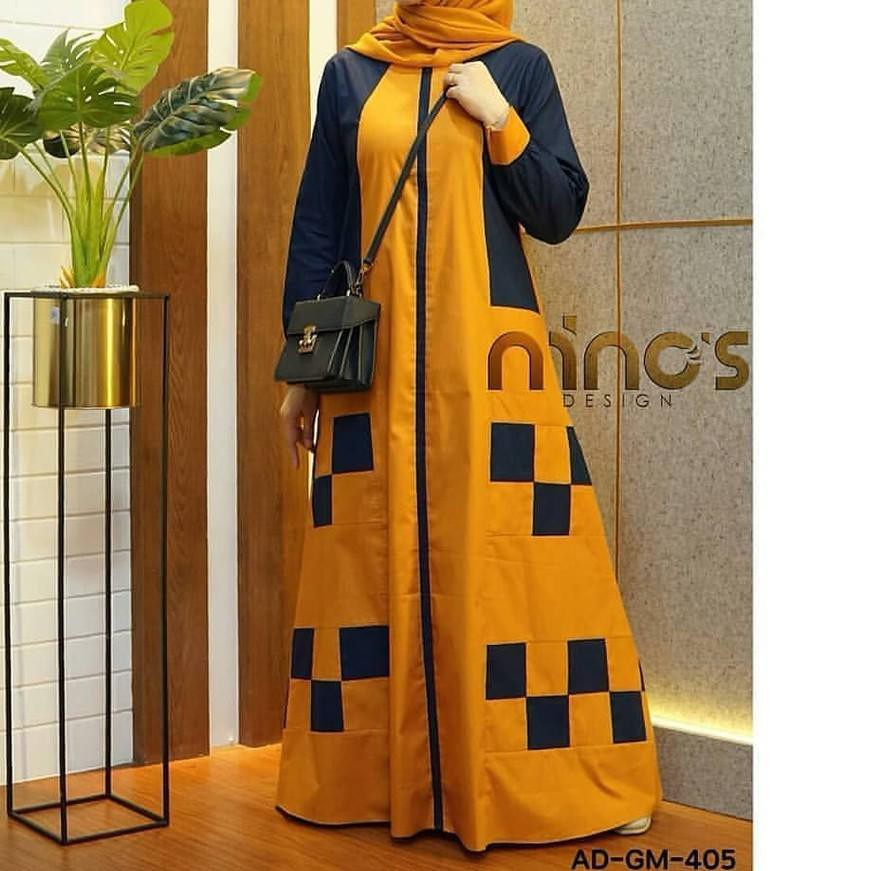

In [5]:
# test if it works
test = pd.read_csv("test.csv")
print(test)

from IPython.display import Image
Image(filename='train/train/train/00/00b32bd5ba9cdd7c2f11e3975b3e54fa.jpg')

# Training

https://www.tensorflow.org/tutorials/load_data/images

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb#scrollTo=DLdCchMdCaWQ

In [29]:
IMG_HEIGHT = 871
IMG_WIDTH = 871
CLASS_NAMES = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14',
               '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
               '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']
LABEL_COLUMN = 'category'
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 32

image_count = 2683 # for 00 only

STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [9]:
list_ds = tf.data.Dataset.list_files(str ('train/train/train/00/*.jpg'))

for f in list_ds.take(5):
  print(f.numpy())

b'train/train/train/00/91506de1921bd9929a46d7196989cfb2.jpg'
b'train/train/train/00/efd41272503b9ba1ecdaa58374dbc1b6.jpg'
b'train/train/train/00/50c9723ea282b0a72a016b6916583e43.jpg'
b'train/train/train/00/2c1da4dc8acd1348bbb169d7ece1afb8.jpg'
b'train/train/train/00/0cd7ff9277e4e222edd4271ba74fbfd9.jpg'


In [22]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [14]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [15]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [25]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (871, 871, 3)
Label:  [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


# Attempt to store as TFRecord?

https://www.tensorflow.org/tutorials/load_data/tfrecord#walkthrough_reading_and_writing_image_data

In [ ]:
def tf_serialize_example(f0,f1):
  tf_string = tf.py_function(
    serialize_example,
    (f0,f1),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar

tf_serialize_example(f0,f1,f2,f3)

In [31]:
filename = '00.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(labeled_ds)

filenames = [labeled_ds]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

AttributeError: ignored